In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

Tomando en cuenta que en las condiciones iniciales

In [2]:
g = 9.81
l = 1

# Usado para las graficas
dot = '\u0307'

E = np.array([1, 3, 5, 10, 15])

phi_init = np.array([0, np.pi/16, np.pi/8, np.pi/6, np.pi/4, np.pi/3])
psi_init = np.array([0, np.pi/16, np.pi/8, np.pi/4, np.pi/3, np.pi/2])

n_interation = int(10e4)

vec = [$\phi$, $\psi$, $p_\phi$, $p_\psi$]

In [3]:
@jit(nopython = True)
def polar_to_cart (phi):
    x = np.zeros((2, len(phi)))
    for i in range(len(phi)):
        x[0, i] = l * np.cos(phi[i]-np.pi/2)
        x[1, i] = l * np.sin(phi[i]-np.pi/2)
    return x

@jit(nopython = True)
def momento_to_velocidad (vec):
    div = 2-(np.cos(vec[0]-vec[1]))**2
    phi_dot = (vec[2]-vec[3]*np.cos(vec[0]-vec[1]))/div
    psi_dot = (2*vec[3]-vec[2]*np.cos(vec[0]-vec[1]))/div
    return np.array([vec[0], vec[1], phi_dot, psi_dot])

@jit(nopython = True)
def function (vec):
    div = 2-(np.cos(vec[0]-vec[1]))**2
    pphi_dot = 2*np.sin(vec[1]-vec[0])*(vec[2]*vec[3]*(np.cos(vec[0]-vec[1]))**2 - (2*vec[3]**2 + vec[2]**2)*np.cos(vec[0]-vec[1]) + 2*vec[2]*vec[3])/div**2 - 2*g*np.sin(vec[0])
    ppsi_dot = 2*np.sin(vec[0]-vec[1])*(vec[2]*vec[3]*(np.cos(vec[0]-vec[1]))**2 - (2*vec[3]**2 + vec[2]**2)*np.cos(vec[0]-vec[1]) + 2*vec[2]*vec[3])/div**2 - g*np.sin(vec[1]) 
    phi_dot = (vec[2]-vec[3]*np.cos(vec[0]-vec[1]))/div
    psi_dot = (2*vec[3]-vec[2]*np.cos(vec[0]-vec[1]))/div
    return np.array([phi_dot, psi_dot, pphi_dot, ppsi_dot])

@jit(nopython = True)
def Runge_Kutta (vec_angulos, h):
    k_1 = h*function(vec_angulos)
    k_2 = h*function(vec_angulos + k_1/2)
    k_3 = h*function(vec_angulos + k_2/2)
    k_4 = h*function(vec_angulos + k_3)
    return vec_angulos + (k_1 + k_2 + k_3 + k_4)/6

@jit(nopython = True)
def run_code(n, j, k):
    vec_Cohete_total = np.zeros((int(n_interation), 4))

    phi_dot_init = np.sqrt(E[n] - 2*g*(1-np.cos(phi_init[j]))- g*(1-np.cos(psi_init[k])))
    ppsi_init = phi_dot_init*(np.cos(psi_init[k]-phi_init[j]))**2
    pphi_init = 2*phi_dot_init

    vec_Cohete_total[0] = np.array([phi_init[j], psi_init[k], pphi_init, ppsi_init])
    t = 0
    h = 0.001
    for i in range(n_interation-1):
        vec_Cohete_total[i+1] = Runge_Kutta(vec_Cohete_total[i], h)
        t = t+ h
    return vec_Cohete_total 


In [4]:
vec_pendulo = run_code(4, 0, 0)
pos_pendulo_1 = polar_to_cart(vec_pendulo[:, 0])
pos_pendulo_2 = pos_pendulo_1 + polar_to_cart(vec_pendulo[:, 1])

f = open("datos.txt", "w")
for i in range(int(n_interation)):
    if i%10 == 0:
        f.write(f"{pos_pendulo_1[0, i]}, {pos_pendulo_1[1, i]}\n")
        f.write(f"{pos_pendulo_2[0, i]}, {pos_pendulo_2[1, i]}\n")
        f.write(f"\n")
f.close()

In [5]:
vec_pendulo_energias = np.zeros((len(E), int(n_interation), 4))
vec_pendulo_energias_velocidad = np.zeros((len(E), int(n_interation), 4))
for i in range(len(E)):
    vec_pendulo_energias[i] = run_code(i, 1, 1)
    for j in range(int(n_interation)):
        vec_pendulo_energias_velocidad[i, j] = momento_to_velocidad(vec_pendulo_energias[i, j])

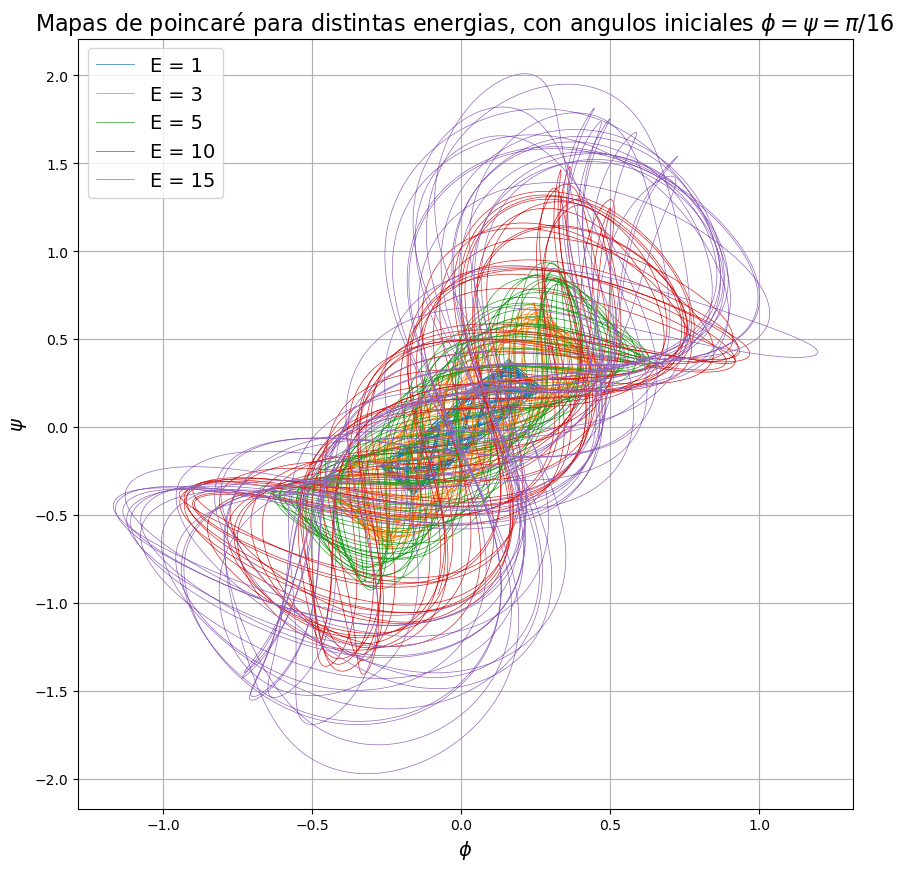

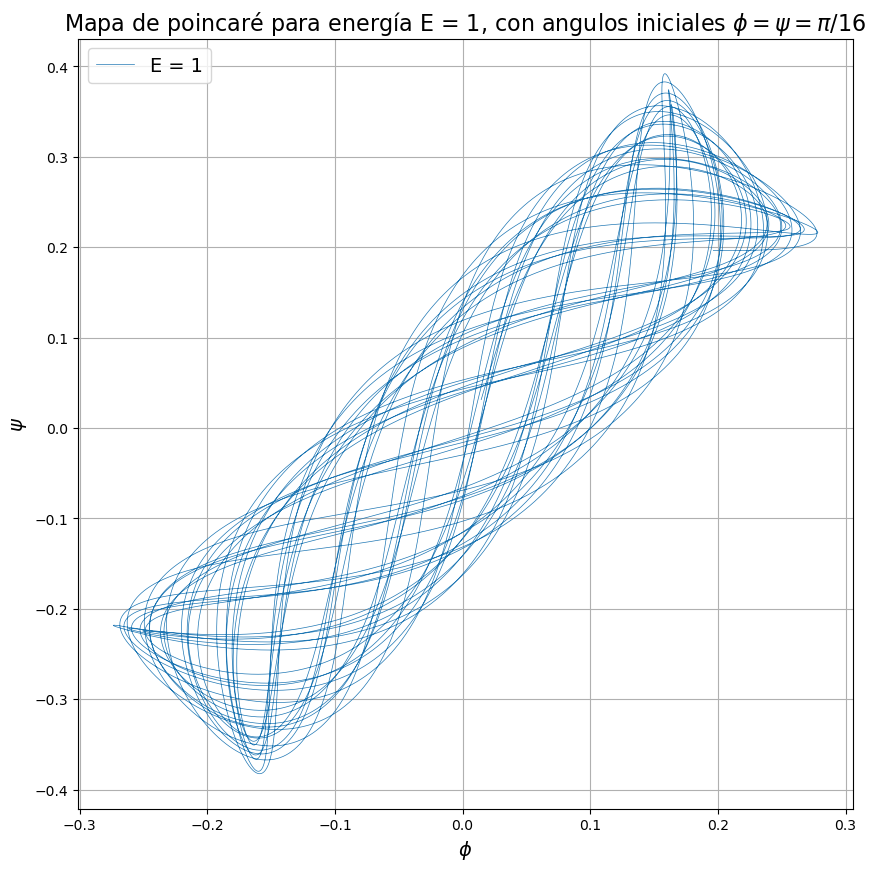

In [6]:
fig=plt.figure(figsize=(10, 10)) #Size of the plot
ax=fig.add_subplot(111)
for i in range(len(E)):
    plt.plot(vec_pendulo_energias[i][:, 0], vec_pendulo_energias[i][:, 1], label=f"E = {E[i]}", lw = 0.5)
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel(r"$\psi$", fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.title(r"Mapas de poincaré para distintas energias, con angulos iniciales $\phi = \psi = \pi /16$ ", fontsize=16)
plt.grid()

plt.savefig(f"latex/plots/poincare_energias.png",  bbox_inches='tight', pad_inches=0.1)

fig=plt.figure(figsize=(10, 10)) #Size of the plot
ax=fig.add_subplot(111)
plt.plot(vec_pendulo_energias[0][:, 0], vec_pendulo_energias[0][:, 1], label=f"E = {E[0]}", lw = 0.5)
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel(r"$\psi$", fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.title(r"Mapa de poincaré para energía E = 1, con angulos iniciales $\phi = \psi = \pi /16$ ", fontsize=16)
plt.grid()

plt.savefig(f"latex/plots/poincare_energias_1.png",  bbox_inches='tight', pad_inches=0.1)

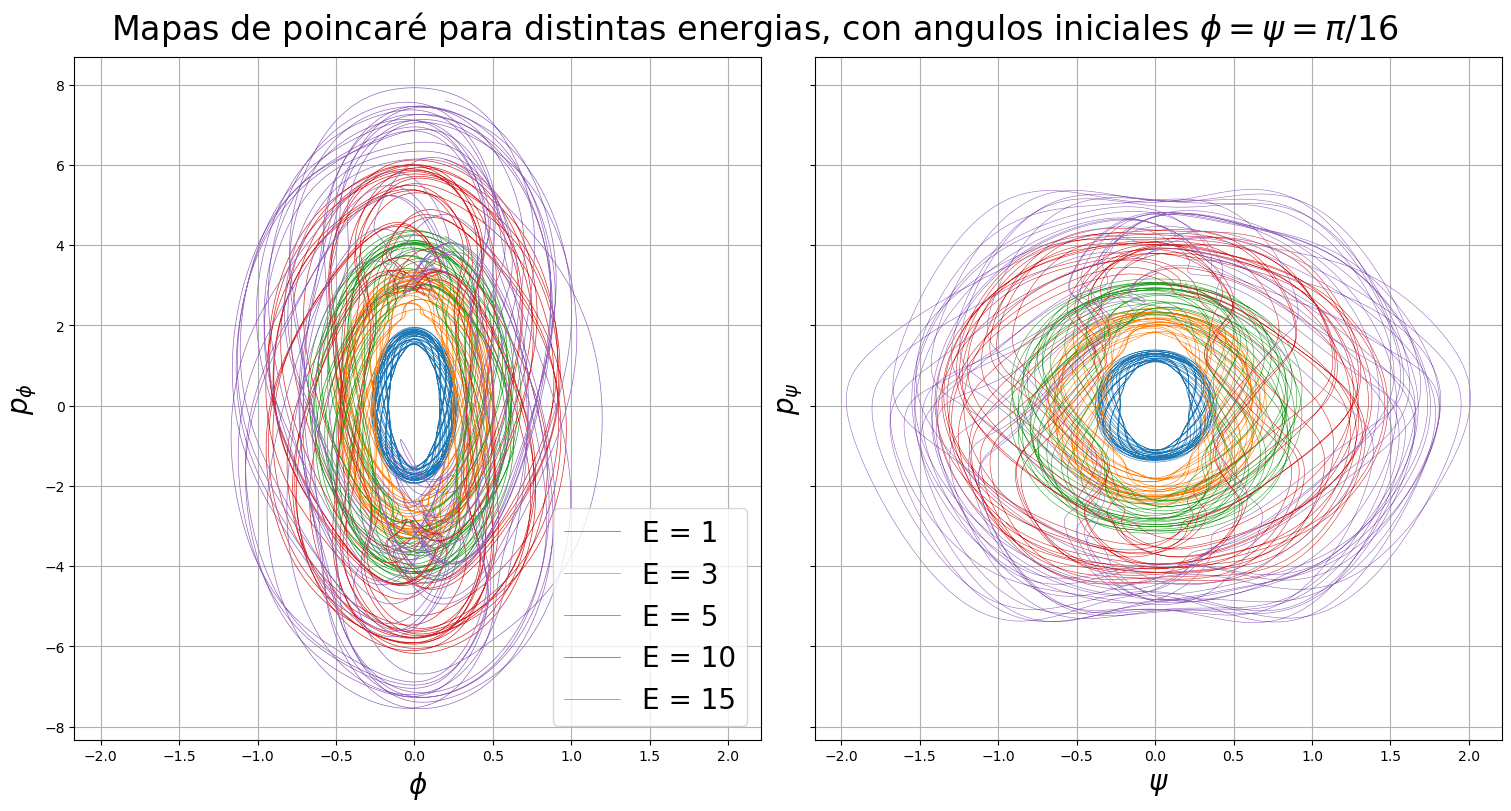

In [7]:
fig, axs = plt.subplots(1, 2, layout='constrained', sharex=True, sharey=True, figsize=(15, 8))
fig.suptitle(r"Mapas de poincaré para distintas energias, con angulos iniciales $\phi = \psi = \pi /16$ ", fontsize=24)
for i in range(len(E)):
    axs[0].plot(vec_pendulo_energias[i][:, 0], vec_pendulo_energias[i][:, 2], label=f"E = {E[i]}", lw = 0.5)
    axs[1].plot(vec_pendulo_energias[i][:, 1], vec_pendulo_energias[i][:, 3], lw = 0.4)
axs[0].set_xlabel(r"$\phi$", fontsize=20)
axs[0].set_ylabel(r"$p_{\phi}$", fontsize=20)
axs[0].legend(fontsize=20)
axs[0].grid()
axs[1].set_xlabel(r"$\psi$", fontsize=20)
axs[1].set_ylabel(r"$p_{\psi}$", fontsize=20)
axs[1].grid()

plt.savefig(f"latex/plots/poincare_energias_momento_phi_psi.png")

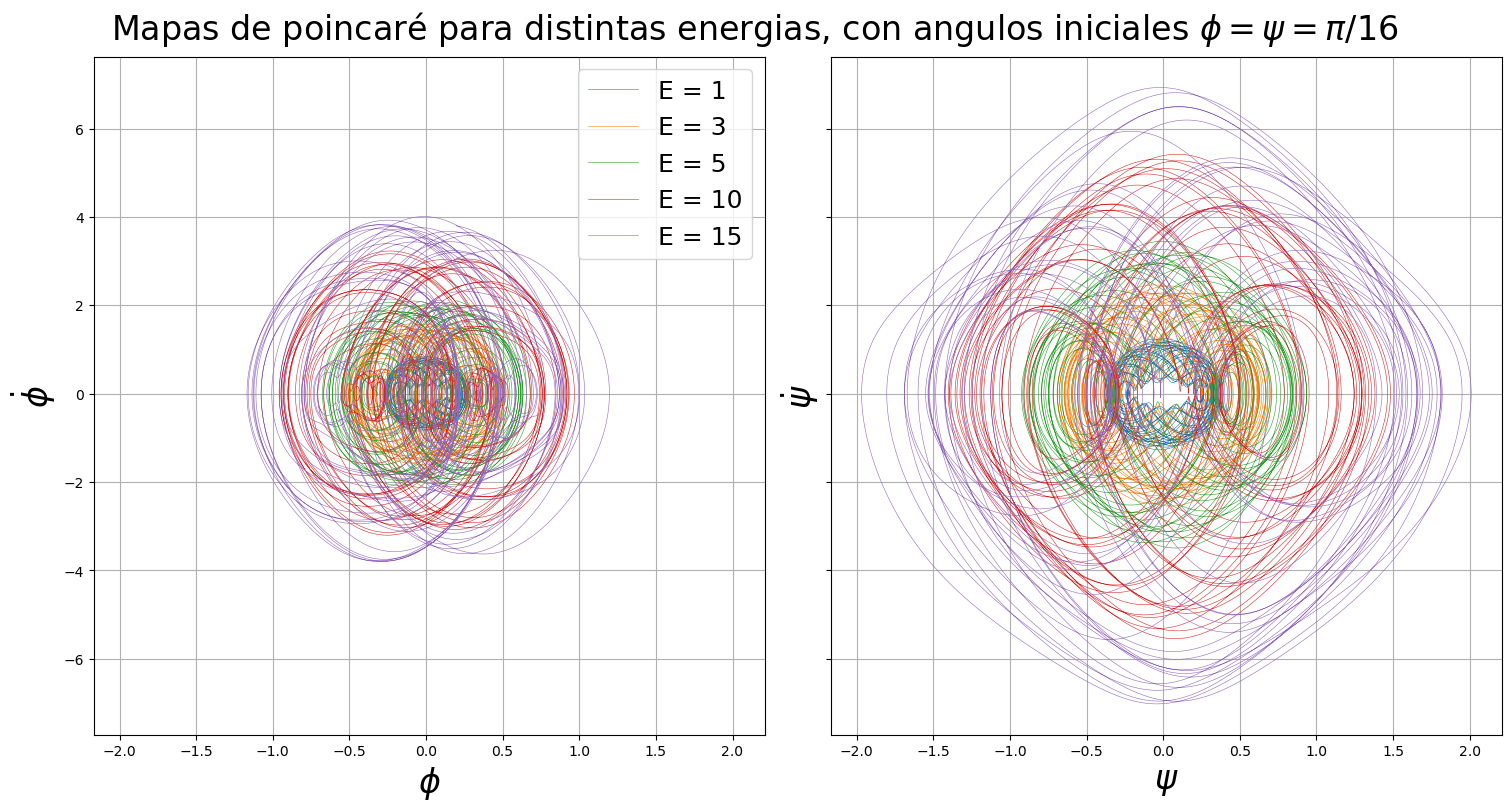

In [12]:
fig, axs = plt.subplots(1, 2, layout='constrained', sharex=True, sharey=True, figsize=(15, 8))
fig.suptitle(r"Mapas de poincaré para distintas energias, con angulos iniciales $\phi = \psi = \pi /16$ ", fontsize=24)
for i in range(len(E)):
    axs[0].plot(vec_pendulo_energias[i][:, 0], vec_pendulo_energias_velocidad[i][:, 2], label=f"E = {E[i]}", lw = 0.4)
    axs[1].plot(vec_pendulo_energias[i][:, 1], vec_pendulo_energias_velocidad[i][:, 3], lw = 0.4)
axs[0].set_xlabel(r"$\phi$", fontsize=24)
axs[0].set_ylabel(r"$\dot{\phi}$", fontsize=24)
axs[0].legend(fontsize=18)
axs[0].grid()
axs[1].set_xlabel(r"$\psi$", fontsize=24)
axs[1].set_ylabel(r"$\dot{\psi}$", fontsize=24)
axs[1].grid()

plt.savefig(f"latex/plots/poincare_energias_phi_psi.png")

In [9]:
vec_pendulo_phi = np.zeros((len(phi_init), int(n_interation), 4))
vec_pendulo_phi_velocidad = np.zeros((len(phi_init), int(n_interation), 4))
for i in range(len(phi_init)):
    vec_pendulo_phi[i] = run_code(4, i, 0)
    for j in range(int(n_interation)):
        vec_pendulo_phi_velocidad[i, j] = momento_to_velocidad(vec_pendulo_phi[i, j])

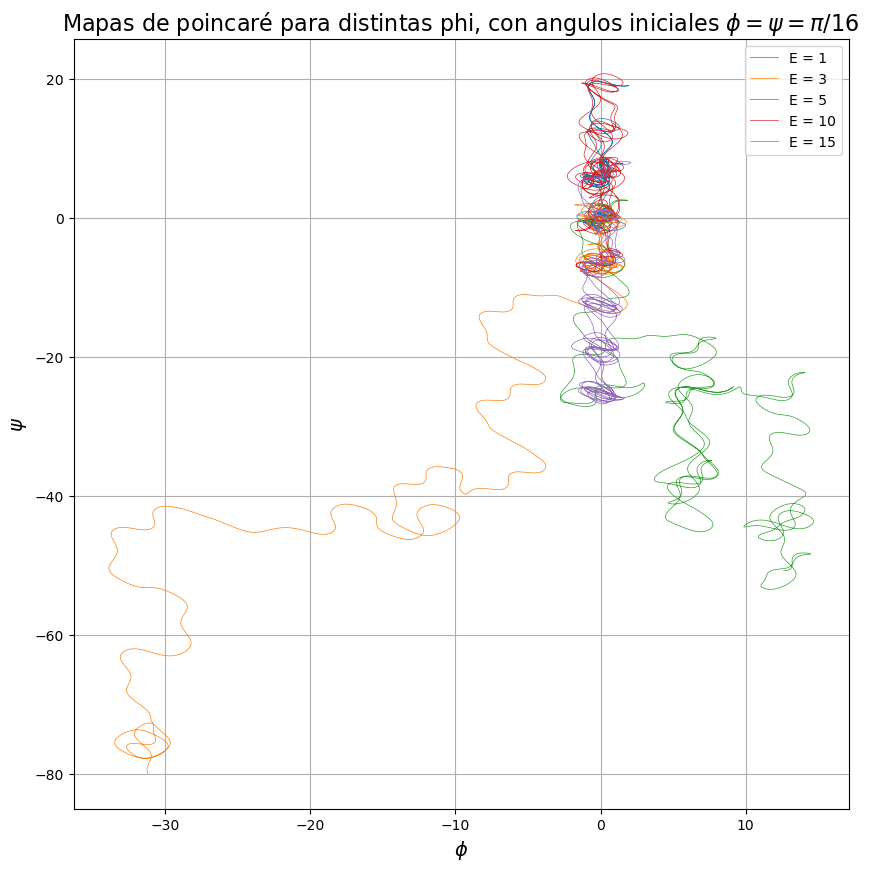

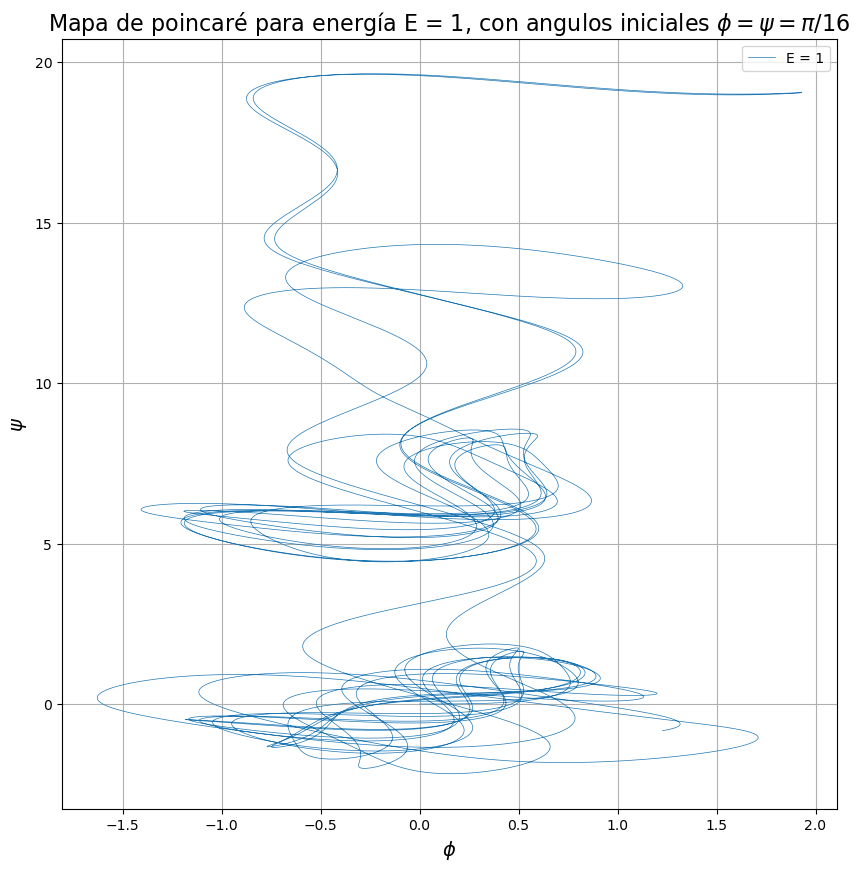

In [10]:
fig=plt.figure(figsize=(10, 10)) #Size of the plot
ax=fig.add_subplot(111)
for i in range(len(E)):
    plt.plot(vec_pendulo_phi[i][:, 0], vec_pendulo_phi[i][:, 1], label=f"E = {E[i]}", lw = 0.5)
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel(r"$\psi$", fontsize=14)
plt.legend()
plt.title(r"Mapas de poincaré para distintas phi, con angulos iniciales $\phi = \psi = \pi /16$ ", fontsize=16)
plt.grid()

plt.savefig(f"latex/plots/poincare_phi.png")

fig=plt.figure(figsize=(10, 10)) #Size of the plot
ax=fig.add_subplot(111)
plt.plot(vec_pendulo_phi[0][:, 0], vec_pendulo_phi[0][:, 1], label=f"E = {E[0]}", lw = 0.5)
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel(r"$\psi$", fontsize=14)
plt.legend()
plt.title(r"Mapa de poincaré para energía E = 1, con angulos iniciales $\phi = \psi = \pi /16$ ", fontsize=16)
plt.grid()

plt.savefig(f"latex/plots/poincare_phi_1.png")